# PIV Analysis Configuration 

This notebook demonstrates how to configure and perform Particle Image Velocimetry (PIV) analysis using RIVeR. We'll cover:
- Setting interrogation window parameters
- Calculating optimal ROI height
- Creating masks for analysis regions
- Running PIV analysis

## Prerequisites

- Completed cross-section definition (03_cross_sections.ipynb)
- Extracted video frames ready for analysis
- Transformation matrix and cross-section data saved

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

# Import RIVeR modules
from river.core.define_roi_masks import (
    recommend_height_roi,
    create_mask_and_bbox
)
from river.core.piv_pipeline import (
    run_test,
    run_analyze_all
)
# Set up paths
frame_dir = Path("data/frames/pisco")
frame_path = Path("data/frames/pisco/0000000004.jpg")
transformation_file = Path("results/pisco/transformation.json")
xsections_file = Path("results/pisco/section.json")
output_dir = Path("results/pisco")

## Step 1: Load Required Data

We'll start by loading our saved transformation matrix, cross-section data, and a sample frame.

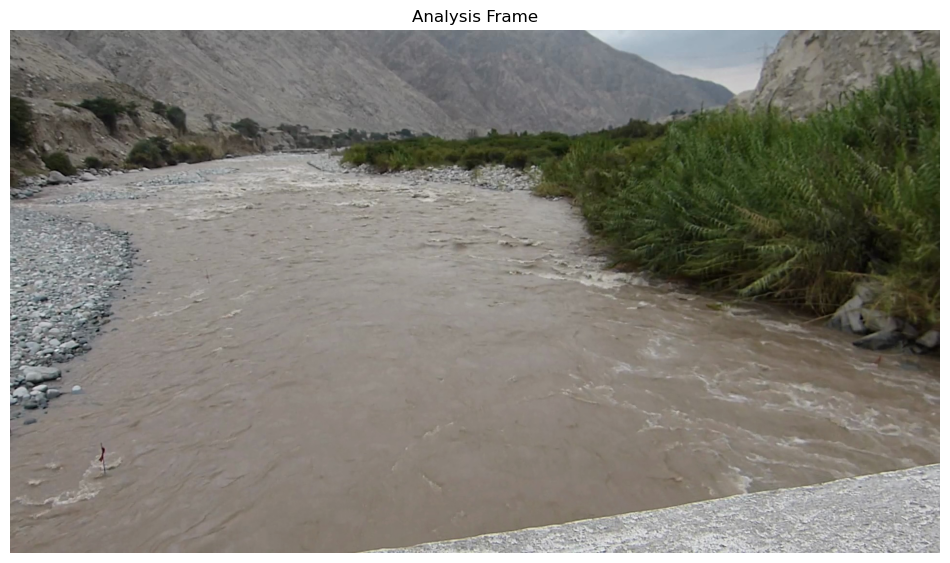

In [2]:
# Load transformation matrix
with open(transformation_file, 'r') as f:
    transformation_matrix = np.array(json.load(f))

# Load cross-sections data
with open(xsections_file, 'r') as f:
    xsections = json.load(f)

# Load and display frame
frame = cv2.imread(str(frame_path))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.axis('off')
plt.title('Analysis Frame')
plt.show()

## Step 2: Define Interrogation Windows

Configure the interrogation windows for PIV analysis:
- First pass window size should be larger to capture larger displacements
- Second pass window size should be smaller for better spatial resolution
- Window overlap determines the density of velocity vectors

In [3]:
# Define PIV analysis parameters
piv_params = {
    "interrogation_area_1": 128,  # Size of first interrogation window
    "interrogation_area_2": 64,   # Size of second interrogation window
    "overlap": 64,              # Size overlap
    "num_stations": xsections["section1"]["num_stations"],
    "window_size": 32           # Base window size for height calculation
}

print("PIV Analysis Parameters:")
print(f"First pass window size: {piv_params['interrogation_area_1']} pixels")
print(f"Second pass window size: {piv_params['interrogation_area_2']} pixels")
print(f"Window overlap: {piv_params['overlap']/piv_params['interrogation_area_1']*100}%")
print(f"Number of stations: {piv_params['num_stations']}")

PIV Analysis Parameters:
First pass window size: 128 pixels
Second pass window size: 64 pixels
Window overlap: 50.0%
Number of stations: 15


## Step 3: Calculate Optimal ROI Height

Calculate the recommended height for the region of interest (ROI) based on the interrogation window size and cross-section geometry.

In [4]:
# Calculate recommended ROI height
height_roi = recommend_height_roi(
    xsections,
    piv_params["interrogation_area_1"],
    transformation_matrix
)

print(f"\nRecommended ROI height: {height_roi:.2f} meters")


Recommended ROI height: 4.00 meters


## Step 4: Create Analysis Mask and Bounding Box

Create a mask and bounding box to optimize PIV analysis performance and focus on relevant areas:

- **ROI (Region of Interest) Bounding Box**: 
  - Defines a rectangular region that encompasses all cross-sections
  - Significantly reduces computation time by limiting PIV analysis to only this region
  - All areas outside this box are excluded from processing entirely

- **Analysis Mask**:
  - Further refines the analysis area within the ROI
  - White areas (mask value = 1) indicate regions where PIV calculations will be retained
  - Black areas (mask value = 0) indicate regions where PIV results will be filtered out
  - Helps eliminate spurious velocities from areas not relevant to the flow analysis
  - Particularly useful for removing:
    - Bank areas
    - Vegetation
    - Static objects
    - Areas outside the water surface

The combination of ROI and mask ensures that:
1. Processing time is minimized by focusing only on relevant areas
2. Memory usage is optimized by excluding unnecessary regions
3. Final results contain only meaningful velocity measurements from the areas of interest

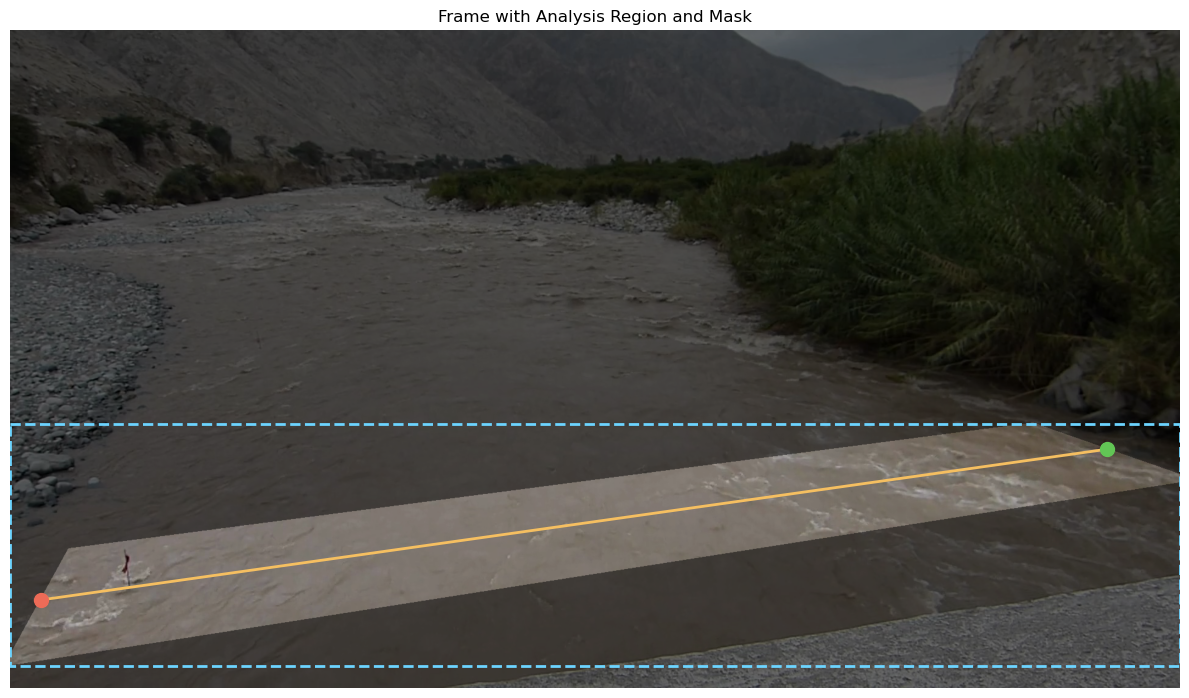


Bounding Box Parameters:
x: 0.0
y: 645.8
width: 1919.0
height: 397.8


In [5]:
# Create mask and get bounding box
mask, bbox = create_mask_and_bbox(
    frame,
    xsections,
    transformation_matrix,
    height_roi
)

# Visualize mask overlaid on the frame
plt.figure(figsize=(12, 8))

# Display the original frame first
plt.imshow(frame_rgb)

# Create black overlay for the entire image
overlay = np.zeros(frame_rgb.shape[:2])  # Single channel black overlay
plt.imshow(overlay, alpha=0.1, cmap='gray')  # Apply with 0.1 opacity

# Remove the overlay where mask is 1
overlay_mask = np.ones(frame_rgb.shape[:2]) * 0.5  # Start with 0.5 opacity everywhere
overlay_mask[mask == 1] = 0  # Make completely transparent where mask is 1
plt.imshow(overlay, alpha=overlay_mask, cmap='gray')


# Add the bounding box with dashed light blue lines
rect = plt.Rectangle(
    (bbox[0], bbox[1]), bbox[2], bbox[3],
    linewidth=2, 
    edgecolor='#6CD4FF',  # Light blue color
    facecolor='none',
    linestyle='--'        # Dashed line
)
plt.gca().add_patch(rect)

# Add the Cross Section
plt.plot([xsections["section1"]["xl"], xsections["section1"]["xr"]], 
         [xsections["section1"]["yl"], xsections["section1"]["yr"]], 
         color='#F5BF61', linewidth=2)  # Line connecting points
plt.plot(xsections["section1"]["xl"], xsections["section1"]["yl"], 'o', color='#ED6B57', markersize=10)  # Left point
plt.plot(xsections["section1"]["xr"], xsections["section1"]["yr"], 'o', color='#62C655', markersize=10)  # Right point

plt.title('Frame with Analysis Region and Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

print("\nBounding Box Parameters:")
print(f"x: {bbox[0]:.1f}")
print(f"y: {bbox[1]:.1f}")
print(f"width: {bbox[2]:.1f}")
print(f"height: {bbox[3]:.1f}")

## Step 5: Test PIV Analysis

Let's perform a test PIV analysis on a pair of consecutive frames to verify our configuration and visualize the results. This test will help us validate our ROI and mask settings before running the full analysis.

Important: The PIV analysis at this stage produces a displacement field measured in pixels - this represents how far features have moved between the two frames. These displacements are not yet true velocities (which would require:
- Conversion from pixel space to real-world coordinates using our transformation matrix
- Division by the time interval between frames to get velocity units (e.g., m/s)

For this test, we'll use default values for the optional parameters. Here are the available options:

- `mask_auto` (default=True): Automatically applies a Gaussian filter to limit peak search area
- `multipass` (default=True): Performs multiple passes to improve accuracy, using the first pass result to guide the second
- `standard_filter` (default=True): Removes outliers based on standard deviation of velocities
- `standard_threshold` (default=4): Number of standard deviations for outlier detection
- `median_test_filter` (default=True): Additional outlier removal using local median test
- `epsilon` (default=0.02): Tolerance parameter for median test filtering
- `threshold` (default=2): Threshold for normalized fluctuations in median test
- `filter_grayscale` (default=True): Converts images to grayscale before processing
- `filter_clahe` (default=True): Applies Contrast Limited Adaptive Histogram Equalization
- `clip_limit_clahe` (default=5): Upper limit for contrast enhancement in CLAHE

This test will help us validate that our PIV settings are appropriate before proceeding with the full analysis and conversion to real-world velocities.

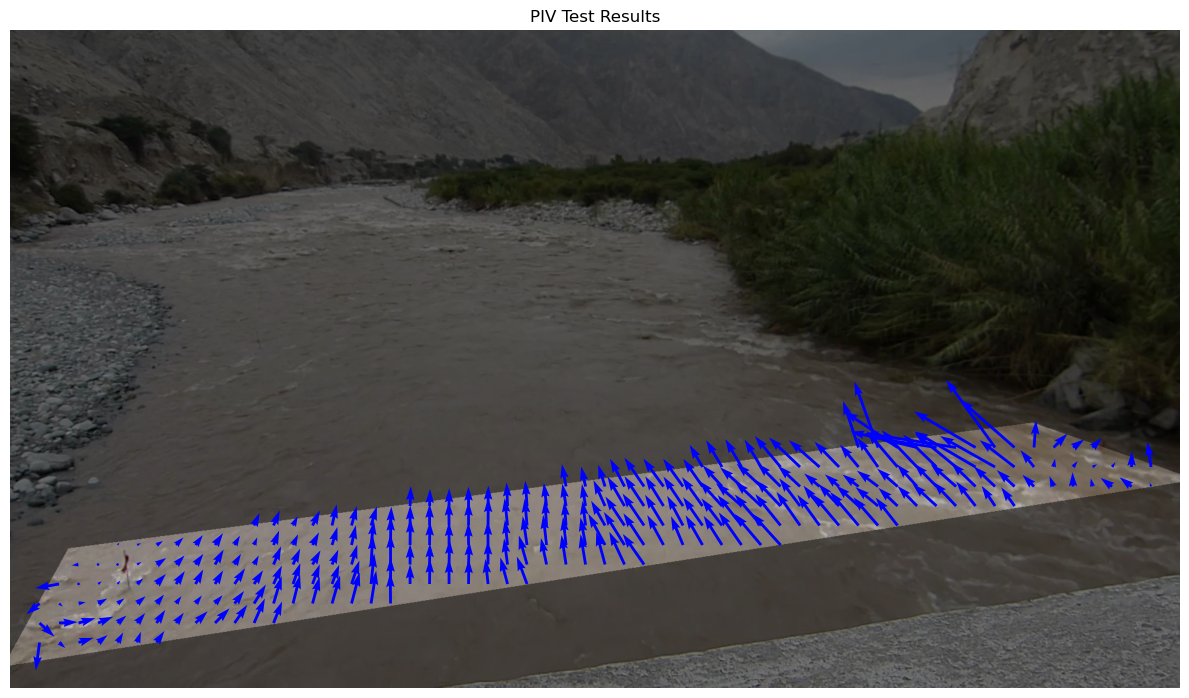

In [6]:
# Get two consecutive frames
frames = sorted(frame_dir.glob("*.jpg"))
frame1_path = frames[0]
frame2_path = frames[1]

# Run PIV test
piv_results = run_test(
    image_1=frame1_path,
    image_2=frame2_path,
    mask=mask,
    bbox=bbox,
    interrogation_area_1=piv_params["interrogation_area_1"],
    interrogation_area_2=piv_params["interrogation_area_2"]
)

# Plot results
plt.figure(figsize=(12, 8))

# Display the first frame
frame1 = cv2.imread(str(frame1_path))
frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
plt.imshow(frame1_rgb)

# Reshape results for quiver plot
x = np.array(piv_results['x']).reshape(piv_results['shape'])
y = np.array(piv_results['y']).reshape(piv_results['shape'])
u = np.array(piv_results['u']).reshape(piv_results['shape'])
v = np.array(piv_results['v']).reshape(piv_results['shape'])

# Display the mask
plt.imshow(overlay, alpha=overlay_mask, cmap='gray')

# Create quiver plot with all displacement vectors
# Create quiver plot with all displacement vectors
# Note: We use -v because the image coordinate system has y-axis inverted
# In images, y increases downward, while in plotting y increases upward
# This inversion ensures the vectors point in the correct physical direction
plt.quiver(x, y, u, -v,color='blue')


plt.title('PIV Test Results')
plt.axis('off')
plt.tight_layout()
plt.show()

## Step 6: Full PIV Analysis and Results Saving

Now that we've validated our PIV configuration through testing, we'll perform the complete analysis on all frames in our dataset. This step:
1. Processes all image pairs in the sequence
2. Computes median displacement fields
3. Visualizes the results
4. Saves the analysis output for later use

### Key Elements of Full Analysis

- **Multiple Frame Processing**: Unlike our test which used just two frames, this analyzes all sequential frame pairs
- **Median Statistics**: Computes statistical measures across all frames to provide:
  - Median displacements (more robust than mean)
  - Temporal variations in the flow field
  - Gradient information for seeding quality assessment

### Output Data Structure

The `piv_results` dictionary contains:
- `shape`: Dimensions of the velocity field grid
- `x`, `y`: Coordinate arrays for vector positions
- `u_median`, `v_median`: Median displacement components
- `u`, `v`: Full displacement time series
- `gradient`: Seeding quality metrics

### Important Notes

1. **Processing Time**: Full analysis may take several minutes depending on:
   - Number of frames
   - Size of ROI
   - Computer processing power

2. **Memory Usage**: Large datasets may require significant RAM
   - Monitor system resources during processing
   - Consider reducing ROI size if memory issues occur

3. **Vector Interpretation**:
   - Displacements are still in pixel units
   - Negative v-values are plotted inverted due to image coordinate system
   - Vectors show median pattern across all frames

4. **Data Storage**:
   - Results are saved in JSON format
   - Large datasets may create substantial files
   - Consider compression for long-term storage

The saved results will be used in subsequent notebooks for:
- Conversion to real-world velocities
- Discharge calculations

Processing 30 frames...


Processing image pairs: 100%|█████████| 29/29 [00:07<00:00,  4.14it/s, ETA=0.0s]
/Users/antoine/river/river/core/piv_pipeline.py:332: RuntimeWarning: All-NaN slice encountered
  u_median = np.nanmedian(dict_cumul["u"], 1)
/Users/antoine/river/river/core/piv_pipeline.py:333: RuntimeWarning: All-NaN slice encountered
  v_median = np.nanmedian(dict_cumul["v"], 1)


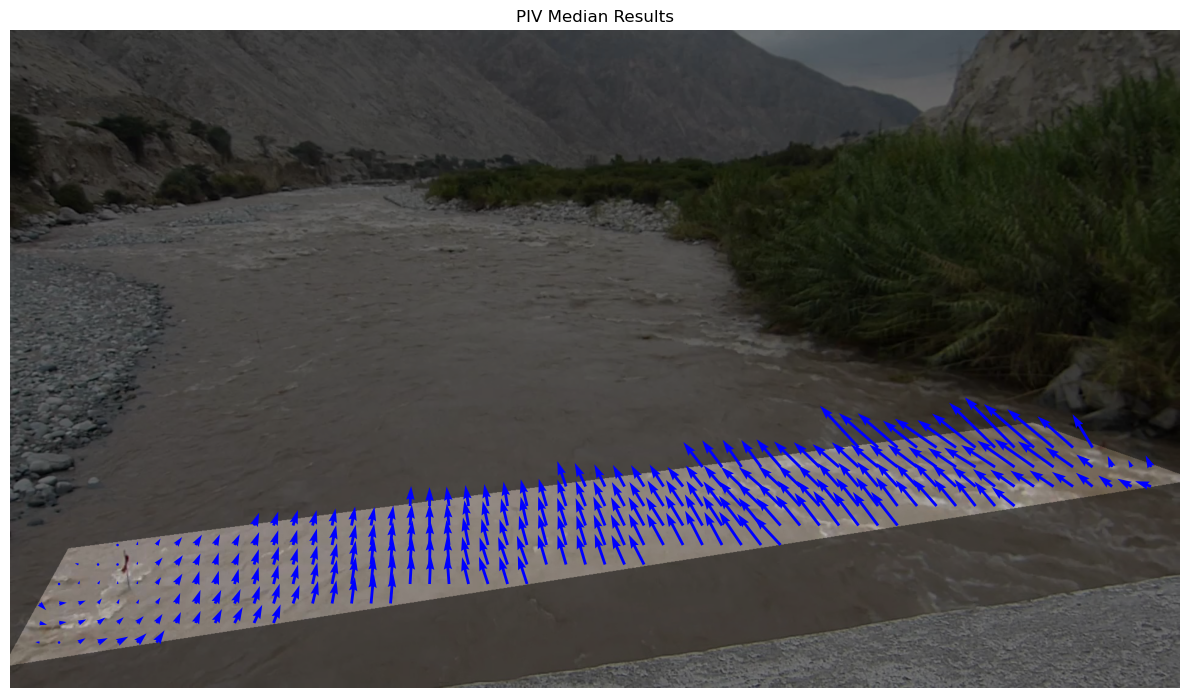


PIV results data saved to results/pisco/piv_results.json


In [7]:
# Run PIV Analisis
piv_results = run_analyze_all(
    frame_dir,
    mask=mask,
    bbox=bbox,
    interrogation_area_1=piv_params["interrogation_area_1"],
    interrogation_area_2=piv_params["interrogation_area_2"]
)

# Plot results
plt.figure(figsize=(12, 8))

# Display the first frame
plt.imshow(frame1_rgb)
x,y,u,v = np.array(piv_results['x']),np.array(piv_results['y']),np.array(piv_results['u_median']),np.array(piv_results['v_median'])

# Display the mask
plt.imshow(overlay, alpha=overlay_mask, cmap='gray')

# Create quiver plot with all displacement vectors
# Create quiver plot with all displacement vectors
# Note: We use -v because the image coordinate system has y-axis inverted
# In images, y increases downward, while in plotting y increases upward
# This inversion ensures the vectors point in the correct physical direction
plt.quiver(x, y, u, -v,color='blue')

plt.title('PIV Median Results')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save cross-sections to JSON
output_file = output_dir / "piv_results.json"
with open(output_file, 'w') as f:
    json.dump(piv_results, f, indent=2)
print(f"\nPIV results data saved to {output_file}")

## Next Steps and Troubleshooting

### Next Steps
- The next notebook (05_velocity_analysis.ipynb) will:
  - Apply PIV analysis using these parameters
  - Calculate velocities and discharges
  - Visualize and validate results

### Troubleshooting Common Issues

1. Interrogation Window Size:
   - Second pass window should be half the size of first pass
   - Ensure window sizes are even numbers for FFT efficiency

2. ROI Height Issues:
   - If too small: velocity measurements may be unstable
   - If too large: may include unwanted areas or increase processing time
   - Adjust based on flow conditions and image quality

3. Mask Creation Problems:
   - Check cross-section coordinates are correctly transformed
   - Verify ROI height is appropriate for your imagery
   - Ensure mask covers the entire area of interest
